<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Обучение-на-модели-LinearRegression" data-toc-modified-id="Обучение-на-модели-LinearRegression-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Обучение на модели LinearRegression</a></span></li><li><span><a href="#Обучение-на-модели--RandomForestRegressor" data-toc-modified-id="Обучение-на-модели--RandomForestRegressor-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Обучение на модели  RandomForestRegressor</a></span></li><li><span><a href="#Обучение-на-модели--LGBMRegressor" data-toc-modified-id="Обучение-на-модели--LGBMRegressor-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Обучение на модели  LGBMRegressor</a></span></li><li><span><a href="#Обучение-на-модели-CatBoostRegressor" data-toc-modified-id="Обучение-на-модели-CatBoostRegressor-3.5"><span class="toc-item-num">3.5&nbsp;&nbsp;</span>Обучение на модели CatBoostRegressor</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# Проект: Прогнозирование заказов такси

Описание исследования:

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Цель исследования:

Провести анализ данных при помощи которых можно будет спрогнозировать количество заказов такси на следующий час.
Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Задачи исследования:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.

Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка данных

In [1]:
#импортируем необходимые библиотеки и инструменты
import pandas as pd
import numpy as np 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from lightgbm.sklearn import LGBMRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from catboost import CatBoostRegressor, Pool
import lightgbm as lgb
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import TimeSeriesSplit
import time

In [2]:
#загрузим данные в data
data =  pd.read_csv('/datasets/taxi.csv')

In [3]:
#просмотрим информацию о data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


в данных всего 2 столбца. это время и количество заказов, в столбце datetime время является объектом, ниже переведем в подходящий формат

In [4]:
# посмотрим на данные таблицы
data.head()

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


In [5]:
#Приведём столбец datetime к формату datetime64
data['datetime']=pd.to_datetime(data['datetime'])

In [6]:
# столбец datetime определим индексом нашей таблицы
data=data.set_index('datetime')

In [7]:
# проверим изменения таблицы
data.head(10)

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
2018-03-01 00:50:00,21
2018-03-01 01:00:00,7
2018-03-01 01:10:00,5
2018-03-01 01:20:00,17


In [8]:
data.tail()

,num_orders
datetime,
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27
2018-08-31 23:40:00,39
2018-08-31 23:50:00,53


In [9]:
# рассмотрим статистические характеристики данных
data.describe()

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


In [10]:
# проверим пропущенные значения в датафрейме.
data.isna().sum()

num_orders    0
dtype: int64

пропущенных значений нет

In [11]:
# выполним ресемплирование по одному часу.
data = data.resample('1H').sum()

In [12]:
# проверим
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


In [13]:
#проверим еще раз данные
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


проверим, в хронологическом ли порядке расположены даты и время, используем атрибут индекса таблицы is_monotonic. Если порядок соблюдён, атрибут вернёт True, если нет — False.

In [14]:
print(data.index.is_monotonic)

True


все верно данные находятся в хронологическом порядке

Вывод по разделу:

Данные содержат информация о заках такси с 1 марта 2018 года, по 31 августа 2018 года.

В данном разделе было выполнено:
- загрузка данных и ее анализ
- Привели столбец datetime к формату datetime64
- установка признака "datetime" в качестве индекса
- Ресемплирование данных по одному часу
- проверили что данные в датафрейме расположены в хронологическом порядке.
- данные были подготовлены для обучения моделей.

## Анализ

В данной главе проведем анализ данных

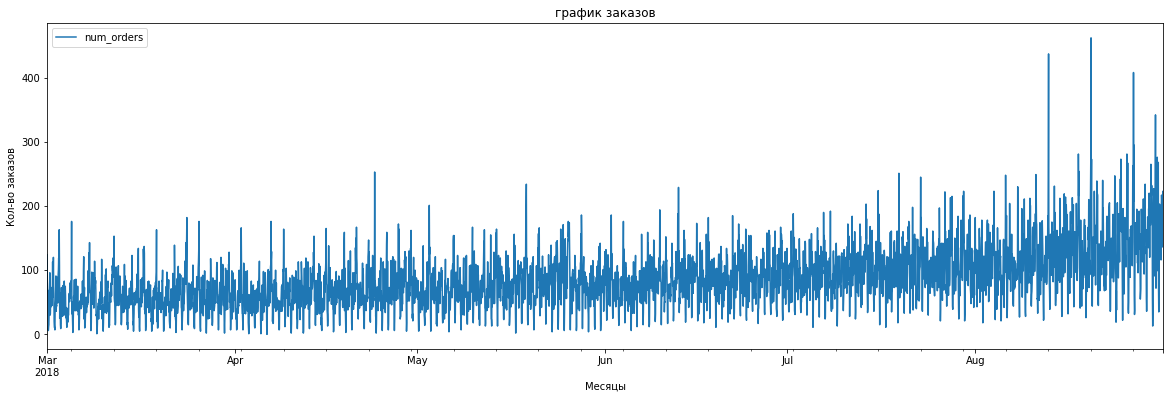

In [15]:
#построим график данных:
figsize = (20,6)
data.plot(figsize=figsize)
plt.title('график заказов')
plt.xlabel('Месяцы')
plt.ylabel('Кол-во заказов')
plt.show()

по графику видно что есть небольшой рост среднего количество заказов с марта по август

Разложим временной ряд на тренд и сезоную составляющие и остаток декомпозиции заказа такси.

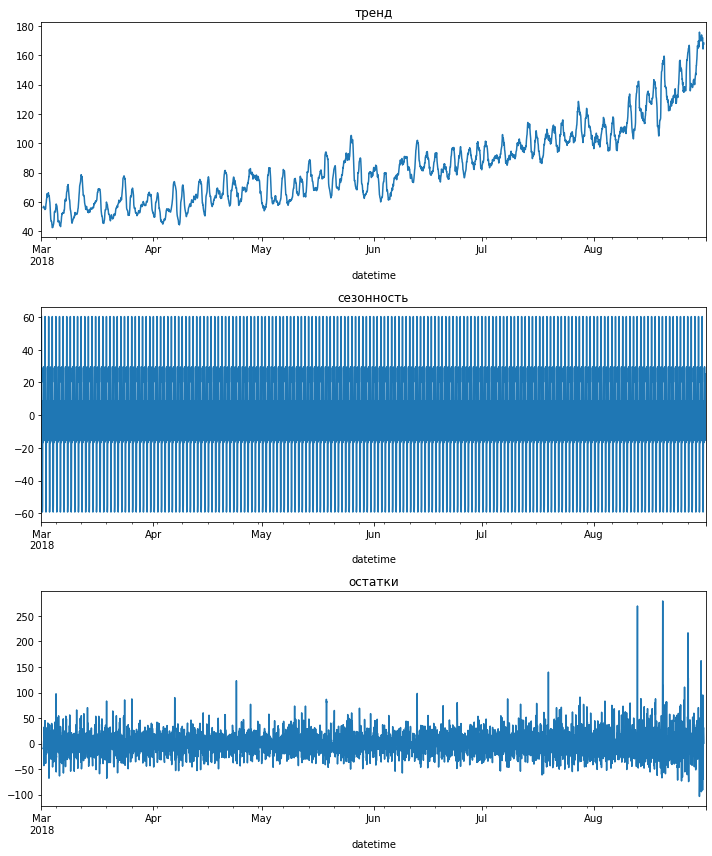

In [16]:
decomposed = seasonal_decompose(data)
plt.figure(figsize=(10, 12))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('тренд')

plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('сезонность')

plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('остатки')

plt.tight_layout()

тренд у нас растущий, количество заказов увеличивается, узнать растут заказаны в связи с сезонностью (весна, лето и прочее) или увеличивается количество пользователей данного такси, не предоставляется возможноным так как мало данных и график сезонности тоже не дает ясности.
рассмотрим сезонность на более коротком промежутке времени.

In [17]:
decomposed=seasonal_decompose(data)

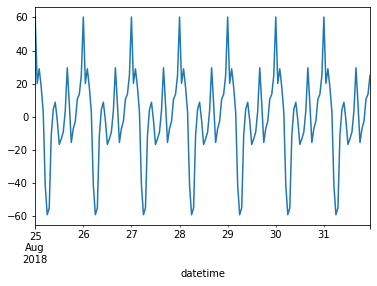

In [18]:
#проверим сезонность за последние 7 дней
decomposed.seasonal['2018-08-25':'2018-08-31'].plot();

внутри дневная сезонность просматривается, к утру спрос падает, к ночи возрастает.

## Обучение

### Подготовка данных

Разбейте датасет о потреблении электроэнергии на обучающую и тестовую выборки в соотношении 4:1. Возьмите данные за доступное время.
lag и rolling_mean примем за 24 часа

In [19]:
def make_features(data, max_lag, rolling_mean_size):
    df = data.copy()
    df['year'] = data.index.year
    df['month'] = data.index.month
    df['day'] = data.index.day
    df['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
 
    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    return data

make_features(data, 24, 24)
print(data.head())
print(data.tail())

                     num_orders  lag_1  lag_2  lag_3  lag_4  lag_5  lag_6  \
datetime                                                                    
2018-03-01 00:00:00         124    NaN    NaN    NaN    NaN    NaN    NaN   
2018-03-01 01:00:00          85  124.0    NaN    NaN    NaN    NaN    NaN   
2018-03-01 02:00:00          71   85.0  124.0    NaN    NaN    NaN    NaN   
2018-03-01 03:00:00          66   71.0   85.0  124.0    NaN    NaN    NaN   
2018-03-01 04:00:00          43   66.0   71.0   85.0  124.0    NaN    NaN   

                     lag_7  lag_8  lag_9  ...  lag_16  lag_17  lag_18  lag_19  \
datetime                                  ...                                   
2018-03-01 00:00:00    NaN    NaN    NaN  ...     NaN     NaN     NaN     NaN   
2018-03-01 01:00:00    NaN    NaN    NaN  ...     NaN     NaN     NaN     NaN   
2018-03-01 02:00:00    NaN    NaN    NaN  ...     NaN     NaN     NaN     NaN   
2018-03-01 03:00:00    NaN    NaN    NaN  ...     NaN  

Разобьм датасет на обучающую и тестовую выборки в соотношении 4:1. Возьмите данные за доступное время.

In [20]:
train, test = train_test_split(data, shuffle=False, test_size=0.1)
train = train.dropna()

features_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']
features_test = test.drop(['num_orders'], axis=1)
target_test = test['num_orders']

Напечатаем на экране минимальные и максимальные значения индексов выборок. 
Они нужны, чтобы убедиться в корректности деления.

In [21]:
print(train.index.min(), train.index.max())
print(test.index.min(), test.index.max())

2018-03-02 00:00:00 2018-08-13 13:00:00
2018-08-13 14:00:00 2018-08-31 23:00:00


In [22]:
print(features_train.shape,features_test.shape)
print(target_train.shape,target_test.shape)

(3950, 25) (442, 25)
(3950,) (442,)


Обучение проведем на 4 моделях LinearRegression, RandomForestRegressor, LGBMRegressor, CatBoostRegressor

в обучении будем использовать кросс-валидацию с параметором TimeSeriesSplit

In [23]:
# TimeSeriesSplit
cv = TimeSeriesSplit(n_splits=5)

###  Обучение на модели LinearRegression

In [24]:
%%time
start = time.time()
model_lr = LinearRegression(12345)
model_lr.fit(features_train, target_train)
 
pred_lr = model_lr.predict(features_train)
rmse_lr = mean_squared_error(target_train, pred_lr, squared=False)

end = time.time()
time_lr = round(end - start,1)

print('RMSE на тренировочной модели LinearRegression =:', rmse_lr.round())
print('время обучения модели LinearRegression:', time_lr)

RMSE на тренировочной модели LinearRegression =: 26.0
время обучения модели LinearRegression: 0.1
CPU times: user 62.1 ms, sys: 51.4 ms, total: 114 ms
Wall time: 96.3 ms


/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass fit_intercept=12345 as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


###  Обучение на модели  RandomForestRegressor

In [25]:
%%time
start = time.time()
model_rfr= RandomForestRegressor(random_state=12345)
gscv = GridSearchCV(model_rfr, param_grid = {"max_depth" : range(1,10),"min_samples_leaf" : range(1,5)}, 
                    scoring='neg_root_mean_squared_error', cv=cv)

rfr_model = gscv.fit(features_train,target_train)

end = time.time()
time_rfr = round(end - start,1)
print(f'Лучшая RMSE: {-rfr_model.best_score_} при параметрах ,{rfr_model.best_params_}')
print(f'RMSE на тренировочной модели RandomForestRegressor = {-rfr_model.best_score_} при параметрах ,{rfr_model.best_params_}')
print('время обучения модели RandomForestRegressor:', time_rfr)

Лучшая RMSE: 26.25863858900084 при параметрах ,{'max_depth': 9, 'min_samples_leaf': 2}
RMSE на тренировочной модели RandomForestRegressor = 26.25863858900084 при параметрах ,{'max_depth': 9, 'min_samples_leaf': 2}
время обучения модели RandomForestRegressor: 164.3
CPU times: user 2min 43s, sys: 524 ms, total: 2min 43s
Wall time: 2min 44s


###  Обучение на модели  LGBMRegressor

In [26]:
%%time
start_time = time.time()
model_lgbm= LGBMRegressor(random_state=12345, n_jobs=2)
gscv = GridSearchCV(model_lgbm, param_grid = {"max_depth" : range(10,15),"n_estimators" : range(20,40)}, 
                       scoring='neg_root_mean_squared_error', cv=cv)

lgbmr_model = gscv.fit(features_train,target_train)
end = time.time()
time_lgbmr = round(end - start,1)
print(f'RMSE на тренировочной модели LGBMRegressor = {-lgbmr_model.best_score_} при параметрах ,{lgbmr_model.best_params_}')
print('время обучения модели LGBMRegressor:', time_lgbmr)

RMSE на тренировочной модели LGBMRegressor = 25.90078728590232 при параметрах ,{'max_depth': 14, 'n_estimators': 39}
время обучения модели LGBMRegressor: 206.5
CPU times: user 41 s, sys: 1.13 s, total: 42.1 s
Wall time: 42.2 s


###  Обучение на модели CatBoostRegressor

In [27]:
%%time
start = time.time()
regressor = CatBoostRegressor(learning_rate=0.1,iterations = 200,random_state=12345, verbose=False,) 

rmse_cbr = (cross_val_score(regressor,features_train, target_train, cv=cv, 
                            scoring='neg_mean_squared_error').mean() * -1) ** 0.5
end = time.time()
time_cbr = round(end - start,1)

print('RMSE на тренировочной модели CatBoostRegressor =:', rmse_cbr)
print('время обучения модели CatBoostRegressor:', time_cbr)

RMSE на тренировочной модели CatBoostRegressor =: 25.64556496310569
время обучения модели CatBoostRegressor: 8.5
CPU times: user 4.01 s, sys: 117 ms, total: 4.13 s
Wall time: 8.48 s


In [28]:
models = [['LinearRegression', time_lr, rmse_lr.round(2)], 
          ['CatBoostRegressor', time_cbr, rmse_cbr.round(2)], 
          ['LGB', time_lgbmr, -lgbmr_model.best_score_.round(2)], 
          ['RandomForestRegressor', time_rfr, -rfr_model.best_score_.round(2)]
         ]
          
data_models = pd.DataFrame(models, columns = ['модель', 'время, сек', 'RMSE']) 
          
print(data_models)

                  модель  время, сек   RMSE
0       LinearRegression         0.1  25.96
1      CatBoostRegressor         8.5  25.65
2                    LGB       206.5  25.90
3  RandomForestRegressor       164.3  26.26


В результате обучения все модели показали результат меньше RMSE = 48.
Лучшими моделями стали CatBoostRegressor показав результат RMSE = 25,65
по времени 11,4 сек. стал лучшим CatBoostRegressor, его и будем использовать для тестирование модели

## Тестирование

Проведем тестирование на модели CatBoostRegressor

In [29]:
%%time

model = CatBoostRegressor(learning_rate=0.1, 
                          iterations = 200, 
                          random_state=12345, 
                          verbose=False) 
model.fit(features_train, target_train)
cbt_predict = model.predict(features_test)
rmse_cbr_test = mean_squared_error(target_test, cbt_predict) ** 0.5
print('RMSE на тестовой модели:', rmse_cbr_test.round())

RMSE на тестовой модели: 43.0
CPU times: user 1.1 s, sys: 20.3 ms, total: 1.12 s
Wall time: 2.02 s


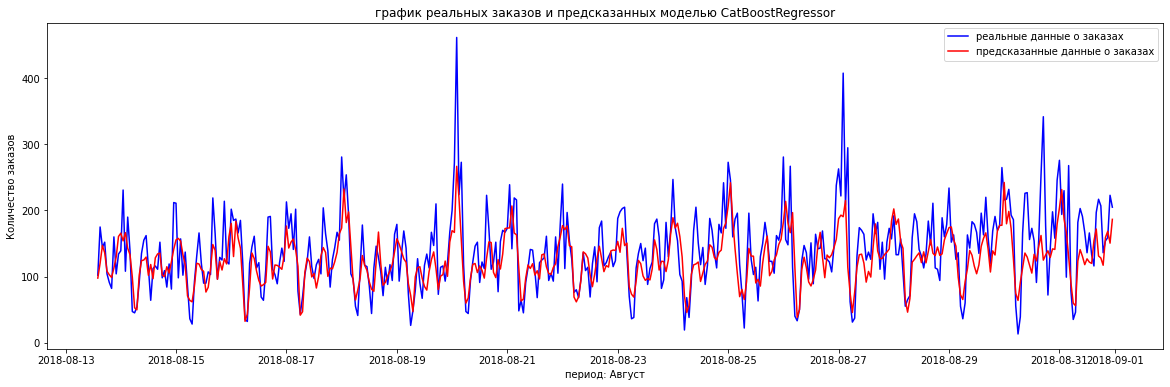

In [30]:
fig, ax = plt.subplots(figsize=figsize)
ax.plot(target_test.index, target_test, 'b-', label='реальные данные о заказах')
ax.plot(target_test.index, cbt_predict, 'r-', label='предсказанные данные о заказах')
plt.title('график реальных заказов и предсказанных моделью CatBoostRegressor')
plt.xlabel('период: Август')
plt.ylabel('Количество заказов')
plt.legend()
plt.show()

 <div class="alert alert-success">
<h2> Комментарий ревьюера <a class="tocSkip"> </h2>

<b>Все отлично!👍:  </b>
    
Отлично, что  визуализированы результаты, показаны предсказанные значения лучшей модели и реальные тестовые

модель CatBoostRegressor показала на тестовой выборки результат RMSE = 43 меньше RMSE = 48
данная модель подходит для решения нашего исследования в прогнозе.